In [1]:

from __future__ import print_function
import pandas as pd
import numpy as np
import re
from tqdm import tqdm,trange
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('C:\\Users\\ASUS\\PycharmProjects\\RahnemaProject')

In [3]:
df = pd.read_csv('pre_processing_v2.csv')


In [4]:
df = df.drop('Unnamed: 0',axis=1)

In [12]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df)
profile.to_file("C:\\Users\\ASUS\\PycharmProjects\\RahnemaProject\\report.html")

GeoLocation

In [5]:
from geolite2 import geolite2

In [10]:

def get_country(ip):
    try:
        x = geo.get(ip)
    except ValueError:
        return np.nan
    try:
        return x['country']['names']['en'] if x else np.nan
    except KeyError:
        return np.nan

In [11]:
geo = geolite2.reader()

unique_ips = df['client_ip'].unique()
unique_ips = pd.Series(unique_ips, index = unique_ips)
df['geolocation'] = df['client_ip'].map(unique_ips.apply(get_country))

geolite2.close()

In [12]:
locations = df['geolocation'].value_counts()
#sns.countplot(locations.loc[0:10])
locations[0:10]

United States        759912
Japan                 76115
China                 62504
France                30593
United Kingdom        27328
Germany               25054
Republic of Korea     14544
Russia                12483
Vietnam               12038
Mexico                 8768
Name: geolocation, dtype: int64

In [ ]:
sns.countplot(df[df['geolocation'] in list(locations[0:10].index),'geolocation'])

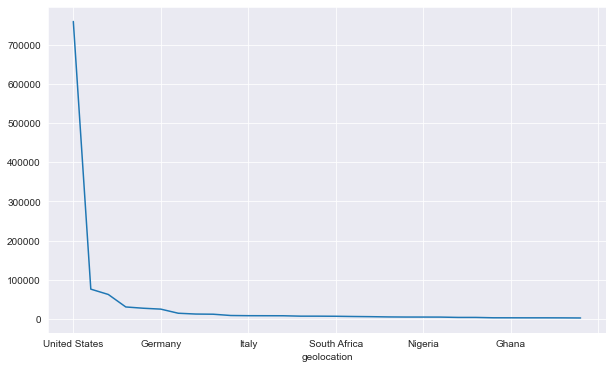

In [45]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
df.groupby('geolocation').count().sort_values('client_ip',ascending=False).iloc[0:30]['client_ip'].plot()

In [47]:
df.isnull().sum()


client_ip              0
date_time              0
status_code            0
response_length        0
user_agent             0
response_time       1718
method                 0
path                   0
geolocation        96940
dtype: int64

Last Refer
---

In [60]:
def get_last_visit(user_refer,index):
    global df
    #rowcopy = user_refer
    ip = user_refer['client_ip']
    #user_agent = df.loc[index, 'user_agent']
    user_agent = user_refer['user_agent']
    #print(type(index))
    temp_df = df[(df['client_ip']==ip)&(df['user_agent']==user_agent)]
    index_refer = temp_df.index.get_loc(index)
    try:
        if index_refer != 0:
            df.loc[index,'last_refer'] = temp_df.iloc[index_refer-1]['date_time']
        else:
            df.loc[index,'last_refer'] = 0
        #return rowcopy
    except IndexError or ValueError:
        df.loc[index,'last_refer'] = 0
        #return rowcopy

In [16]:
#df['last_refer'] = df.apply(lambda row:get_last_visit(row,row.name) ,axis=1)


df['last_refer'] = df.groupby(['client_ip','user_agent'])['date_time'].shift(1)
df['last_page'] = df.groupby(['client_ip','user_agent'])['coded_path'].shift(1)


Path Analysis
---


In [13]:
path = {}
value = 1

In [14]:
def path_address(url_path):
    global path,value
    url = url_path.split('/')
    coded_path = []
    if url[0]=='':
        if url[1]!='api':
            for i in url[1:-1]:
                if i in path.keys():
                    coded_path.append(path[i])
                else:
                    path[i]=value
                    value = value+1
        else:
            for i in url[1:]:
                if i in path.keys():
                    coded_path.append(path[i])
                else:
                    path[i]=value
                    value = value+1
    else:
        for i in url[0:-1]:
            if i in path.keys():
                coded_path.append(path[i])
            else:
                path[i]=value
                value = value+1
    return '-'.join(map(str,coded_path))

In [15]:
df['coded_path'] = df['path'].apply(lambda x:path_address(x))

In [45]:
df['coded_path'].unique()

array(['', '1', '1-3', '5', '6', '4', '8', '9', '1-2', '4-7', '16',
       '1-17', '12', '12-18-19', '12-13-14', '1-21', '12-18', '15', '10',
       '4-20', '28', '10-25', '12-18-22', '24-15', '24-10', '12-13', '24',
       '12-24', '34-35', '1-33', '4-40', '10-31', '24-34-35', '41',
       '24-28', '12-19', '12-48-49', '4-27', '24-10-31', '12-24-36',
       '12-13-32', '12-47-19', '24-10-53', '59-12-60-61', '12-56-57-58',
       '44', '10-43', '34', '74', '10-53', '71', '34-73', '10-85',
       '1-92-93', '24-44', '24-10-70', '24-10-94', '24-9', '24-10-103',
       '24-10-25', '24-10-85', '24-10-79', '4-28', '10-51',
       '12-24-36-108', '1-92', '1-92-117', '10-103', '10-78', '10-94',
       '39', '12-24-36-137', '10-118', '10-89', '12-122-123-124',
       '12-52-19', '68', '34-41', '10-109', '24-10-164', '24-10-69',
       '10-26', '12-24-36-167', '10-127', '24-10-115', '10-163',
       '24-10-11', '10-105', '10-69', '187', '10-166', '10-102',
       '24-10-192', '10-70', '10-143',

In [46]:
df.isnull().sum()

client_ip              0
date_time              0
status_code            0
response_length        0
user_agent             0
response_time       1718
method                 0
path                   0
geolocation        96940
coded_path             0
dtype: int64

In [1]:
#for i in list(path.keys()):
 #   if i.startswith('l'):
  #      print(i.value)

In [102]:
df['coded_path'] = df['coded_path'].apply(lambda x:0 if x=='' else x )


In [ ]:
df.head()

In [111]:
df.to_csv('Feature_extracted.csv',index=False)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260035 entries, 0 to 1260034
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   client_ip        1260035 non-null  object 
 1   date_time        1260035 non-null  object 
 2   status_code      1260035 non-null  int64  
 3   response_length  1260035 non-null  int64  
 4   user_agent       1260035 non-null  object 
 5   response_time    1258317 non-null  float64
 6   method           1260035 non-null  object 
 7   path             1260035 non-null  object 
 8   geolocation      1163095 non-null  object 
 9   last_refer       1208910 non-null  object 
 10  coded_path       1260035 non-null  object 
 11  last_page        1208910 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 115.4+ MB
